In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHALLENS=3

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Potato Disease Classification/Potato-images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch ,lable_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


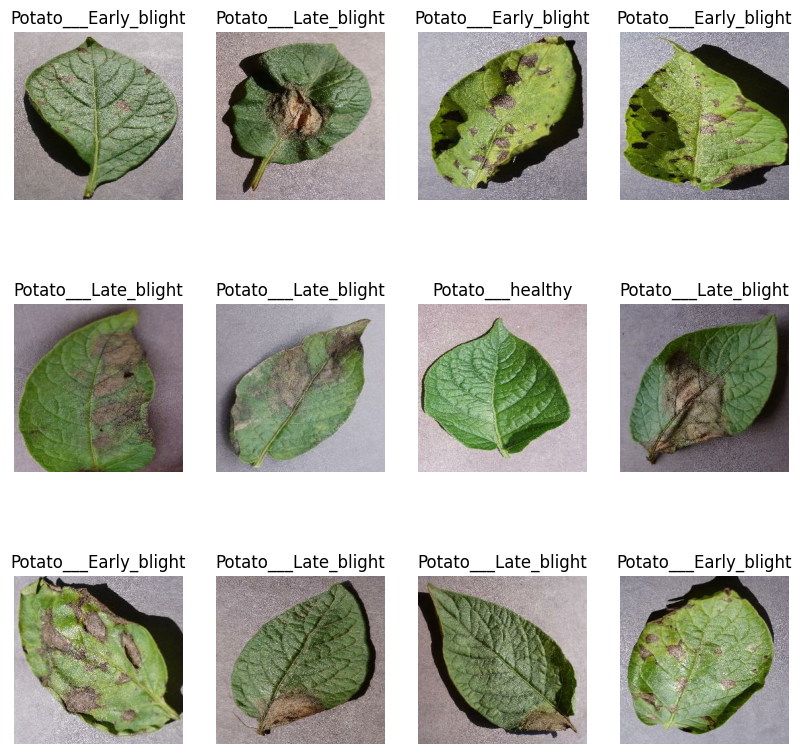

In [8]:
plt.figure(figsize=(10,10))
for image_batch ,lable_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")


In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  # The remaining data is used for test

    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds=get_dataset_partition(dataset)

In [17]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
from tensorflow.keras import layers
import tensorflow as tf

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


In [19]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
input_shape= (IMAGE_SIZE, IMAGE_SIZE,BATCH_SIZE, CHALLENS)
n_classes =3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (256, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (256, 127, 127, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (256, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (256, 62, 62, 64)         0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
EPOCHS = 20
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to determine stopping
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation performance
)

# Train the model with early stopping
history = model.fit(
    train_ds,  # Training dataset
    epochs=EPOCHS,  # Number of epochs to train (will stop earlier if necessary)
    batch_size=BATCH_SIZE,  # Batch size for training
    verbose=1,  # Print training progress
    validation_data=val_ds,  # Validation dataset
    callbacks=[early_stopping]  # Use early stopping callback
)

# Optionally, after training you can save the model and history as discussed earlier


Epoch 1/20
54/54 [==============================] - 30s 497ms/step - loss: 0.0645 - accuracy: 0.9765 - val_loss: 0.1685 - val_accuracy: 0.9531
Epoch 2/20
54/54 [==============================] - 30s 493ms/step - loss: 0.0650 - accuracy: 0.9736 - val_loss: 0.2560 - val_accuracy: 0.9062
Epoch 3/20
54/54 [==============================] - 30s 497ms/step - loss: 0.0429 - accuracy: 0.9853 - val_loss: 0.3710 - val_accuracy: 0.8854
Epoch 4/20
54/54 [==============================] - 30s 491ms/step - loss: 0.0805 - accuracy: 0.9736 - val_loss: 0.0676 - val_accuracy: 0.9792
Epoch 5/20
54/54 [==============================] - 30s 492ms/step - loss: 0.0744 - accuracy: 0.9695 - val_loss: 0.2606 - val_accuracy: 0.9219
Epoch 6/20
54/54 [==============================] - 30s 500ms/step - loss: 0.0686 - accuracy: 0.9780 - val_loss: 0.1493 - val_accuracy: 0.9479
Epoch 7/20
54/54 [==============================] - 30s 507ms/step - loss: 0.0454 - accuracy: 0.9847 - val_loss: 0.2465 - val_accuracy: 0.9219

In [28]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 1s 103ms/step - loss: 0.0754 - accuracy: 0.9570


In [29]:
scores

[0.07541371136903763, 0.95703125]

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
# Retrieve the accuracy, validation accuracy, loss, and validation loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

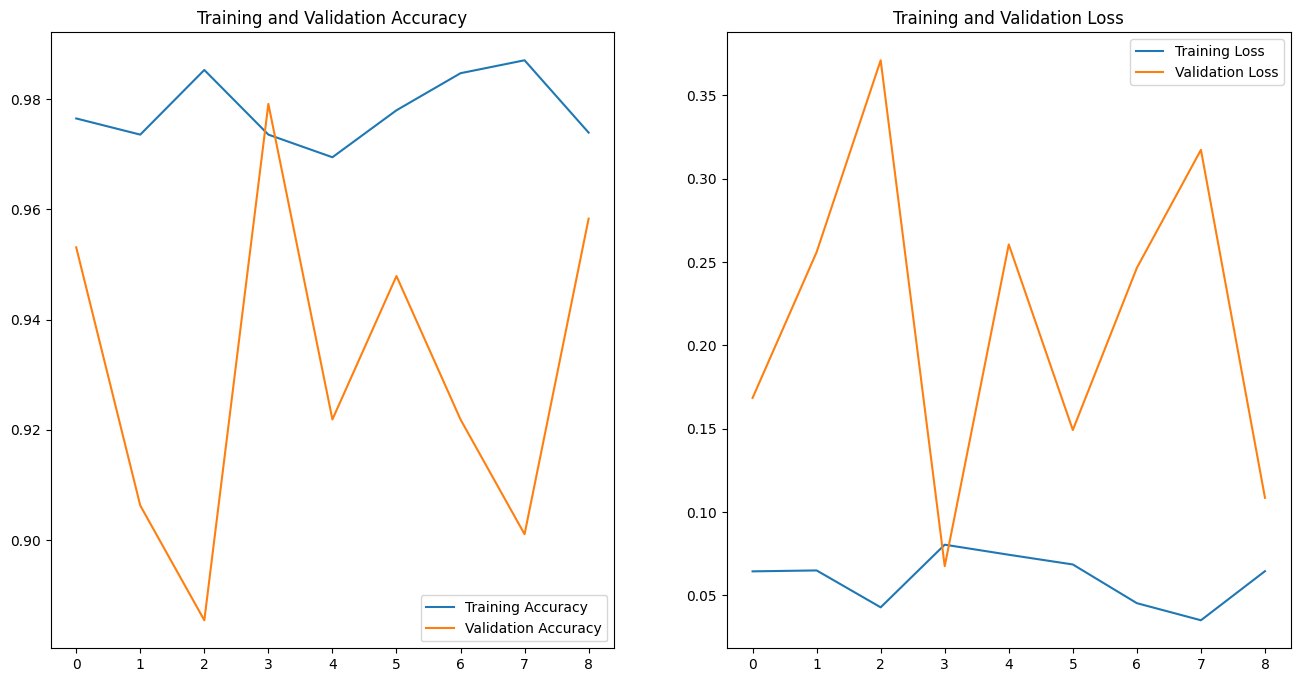

In [35]:
# Get the number of completed epochs
epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)  # First subplot for Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # Second subplot for Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 146ms/step
predicted label: Potato___Early_blight


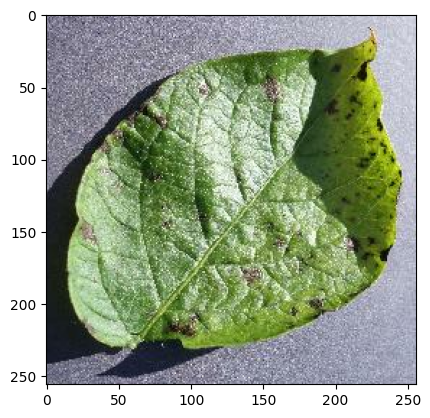

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

Output hidden; open in https://colab.research.google.com to view.

In [45]:
model_version=1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Potato Disease Classification/models/{model_version}")